In [13]:
import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from data.data_loader import generateGauss, generateUniform
from utils.integral import grid
from Models.clustering import FCF
from utils.vis import plotHeatmap_U, plotPDF_Theta, plot_OF, temp, plot_silhouette_values, plot_CVI_with_k

In [15]:
# bandwidth = 0.01
# grid_x    = grid(bandwidth, start=-5, end=15)
# mu        = np.array([0.3, 4.0, 9.1, 1.0, 5.5, 8.0, 4.8])

# # Chọn độ rộng cố định cho Uniform
# width = 2.0

# # Tính a và b sao cho mean = mu
# a_list = mu - width / 2
# b_list = mu + width / 2

# # Gọi lại hàm generateUniform
# F_data = generateUniform(a_list, b_list, grid_x)

In [16]:
bandwidth = 0.01
grid_x    = grid(bandwidth, start=-5, end=15)
mu        = np.array([0.3, 4.0, 9.1, 1.0, 5.5, 8.0, 4.8])
sig       = np.ones_like(mu)
F_data    = generateGauss(mu, sig, grid_x)

In [17]:
cluster=FCF.Model(
   grid_x=grid_x,
   seed=42,
    num_clusters=3,
    fuzziness= 2,
    max_iterations= 100,
    tolerance= 1e-6,
    distance_metric= 'L2',
    verbose = False
   #  centroid_mode="frechet"
)
cluster.fit(F_data)
U, Theta, J = cluster.get_results()
labels = cluster.get_hard_assignments()

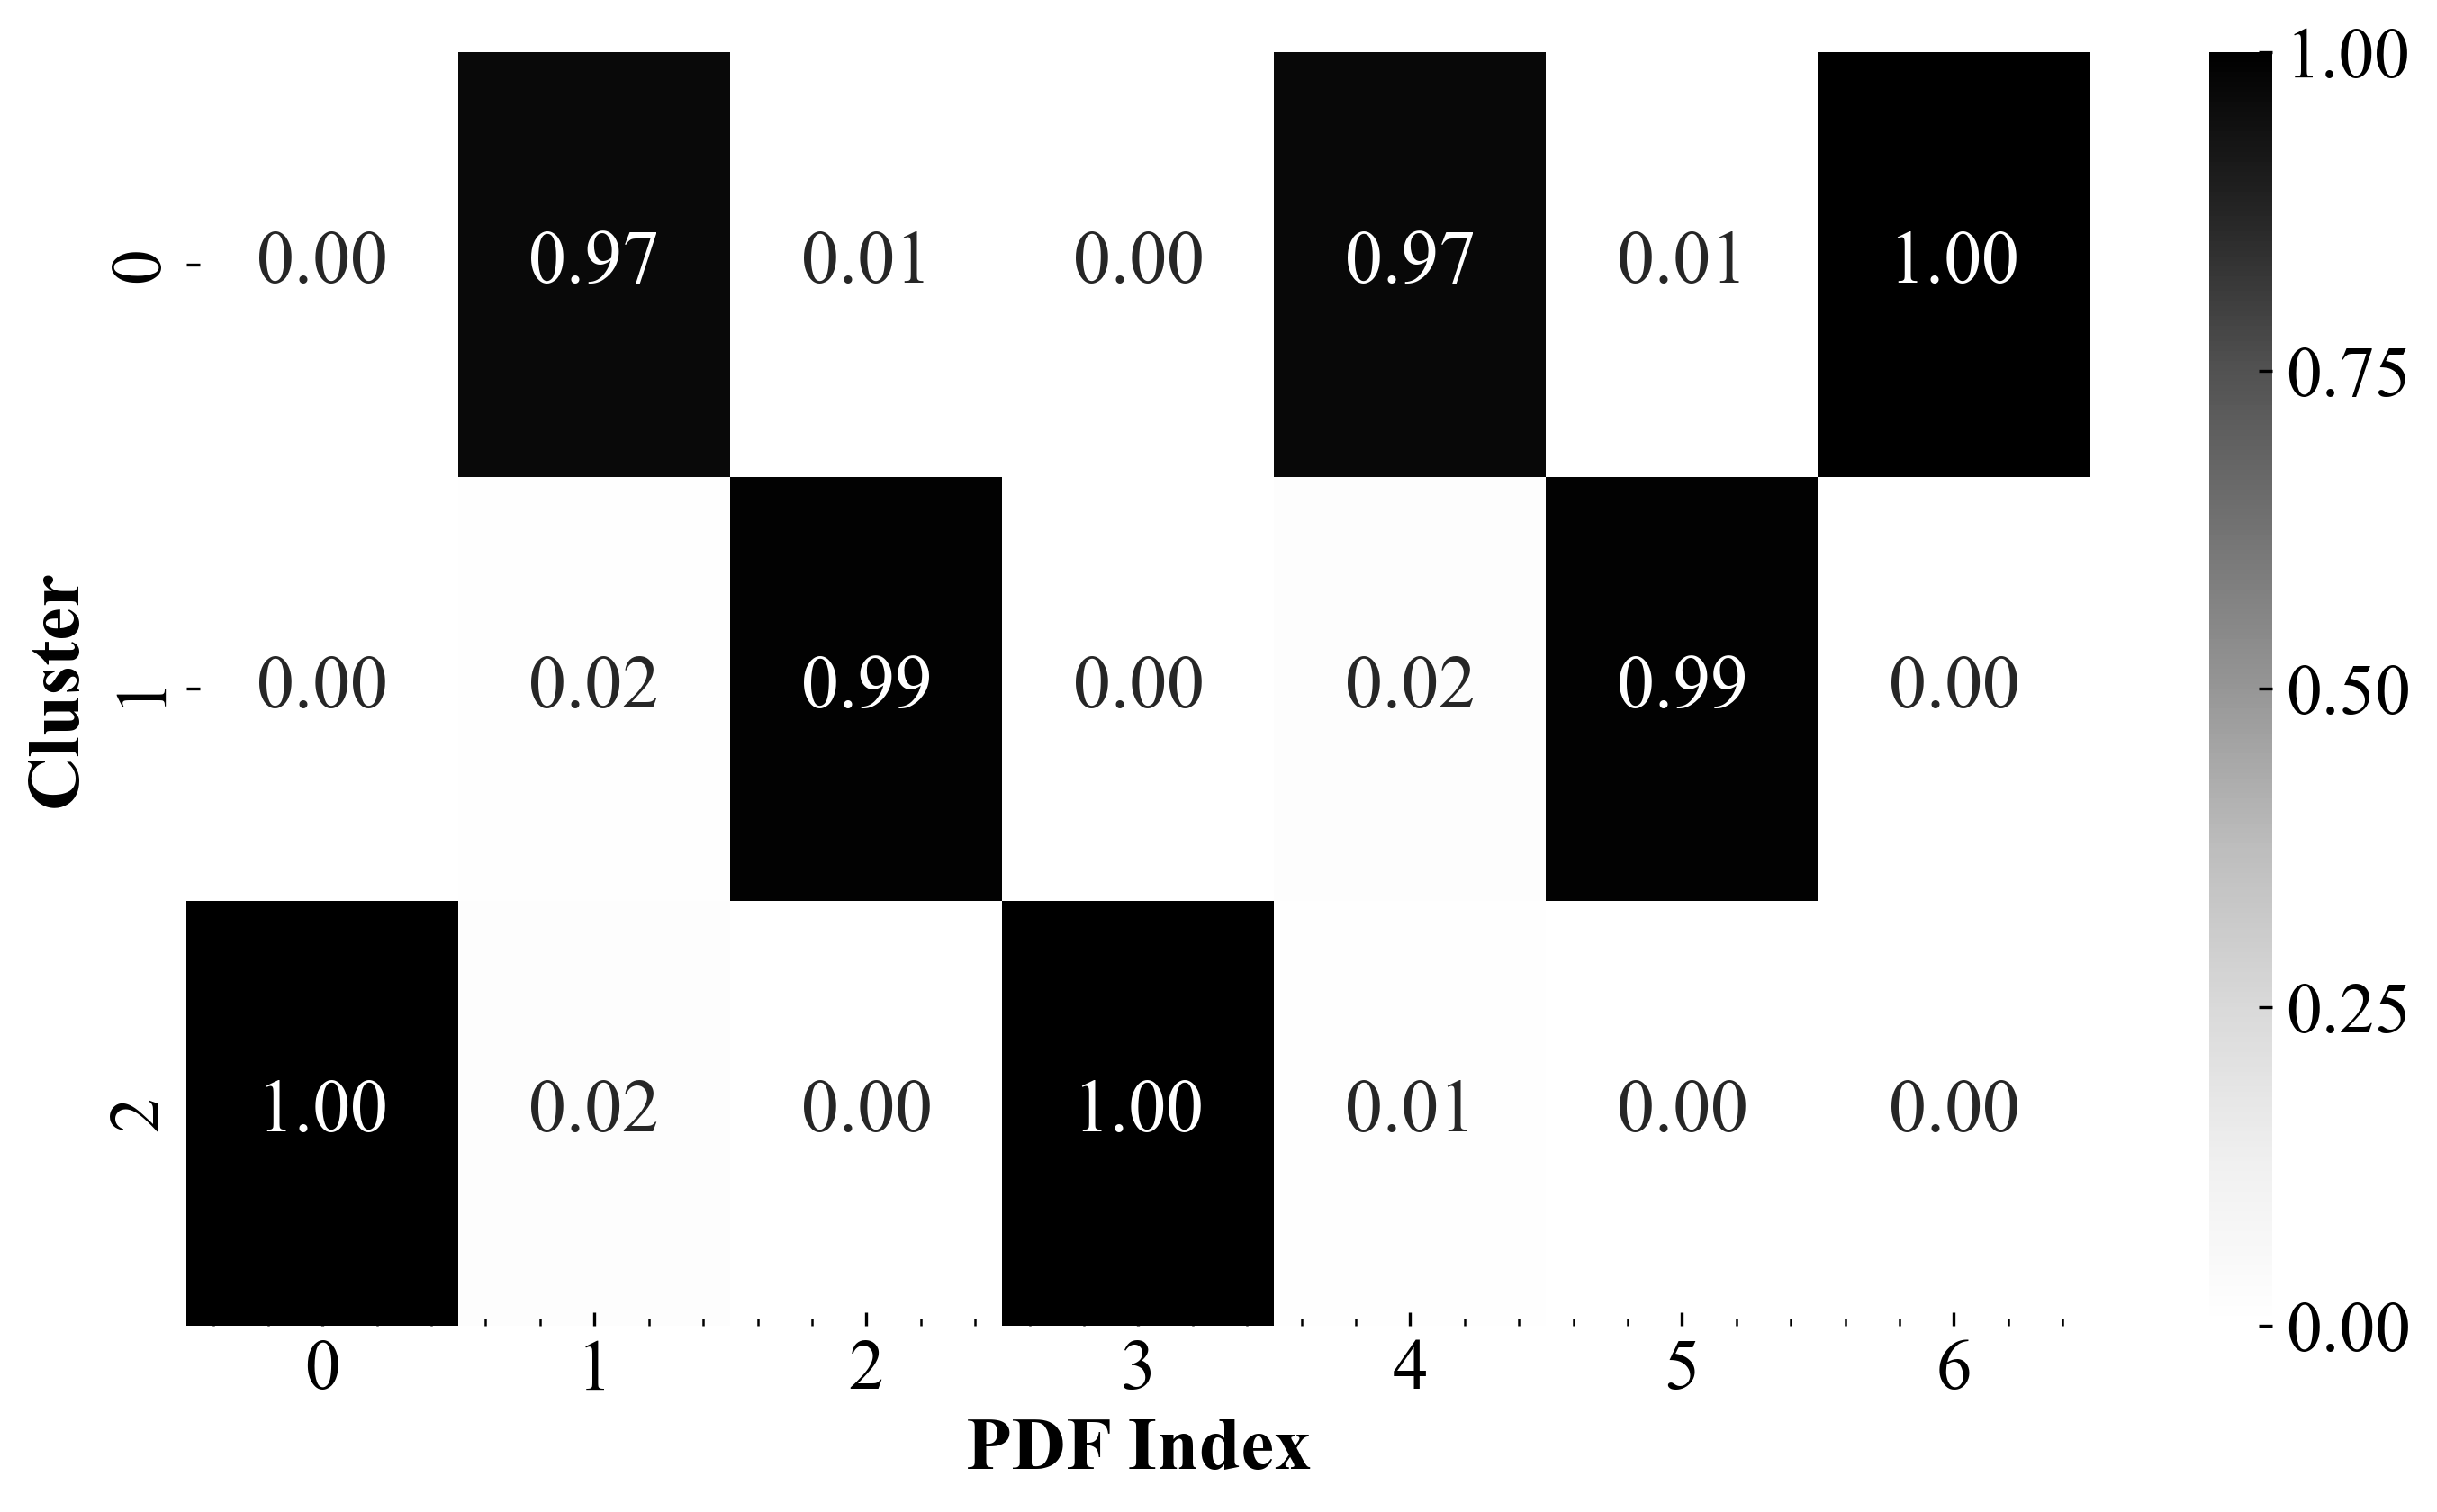

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

U = np.asarray(U, dtype=float)

plt.figure(figsize=(10, 6))
temp(fontsize=20)

ax = sns.heatmap(
	U,
	annot=True,
	fmt=".2f",
	cmap="Greys",
	cbar=True,
	vmin=0.0,           # ép min = 0
	vmax=1.0,           # ép max = 1
	cbar_kws={
		"ticks": np.linspace(0, 1, 5),  # 0, 0.2, ..., 1.0
		"format": "%.2f",
	},
)

ax.set_ylabel("Cluster")
ax.set_xlabel("PDF Index")
ax.figure.tight_layout()
# ax.figure.savefig("FCF_U9.pdf", bbox_inches="tight")


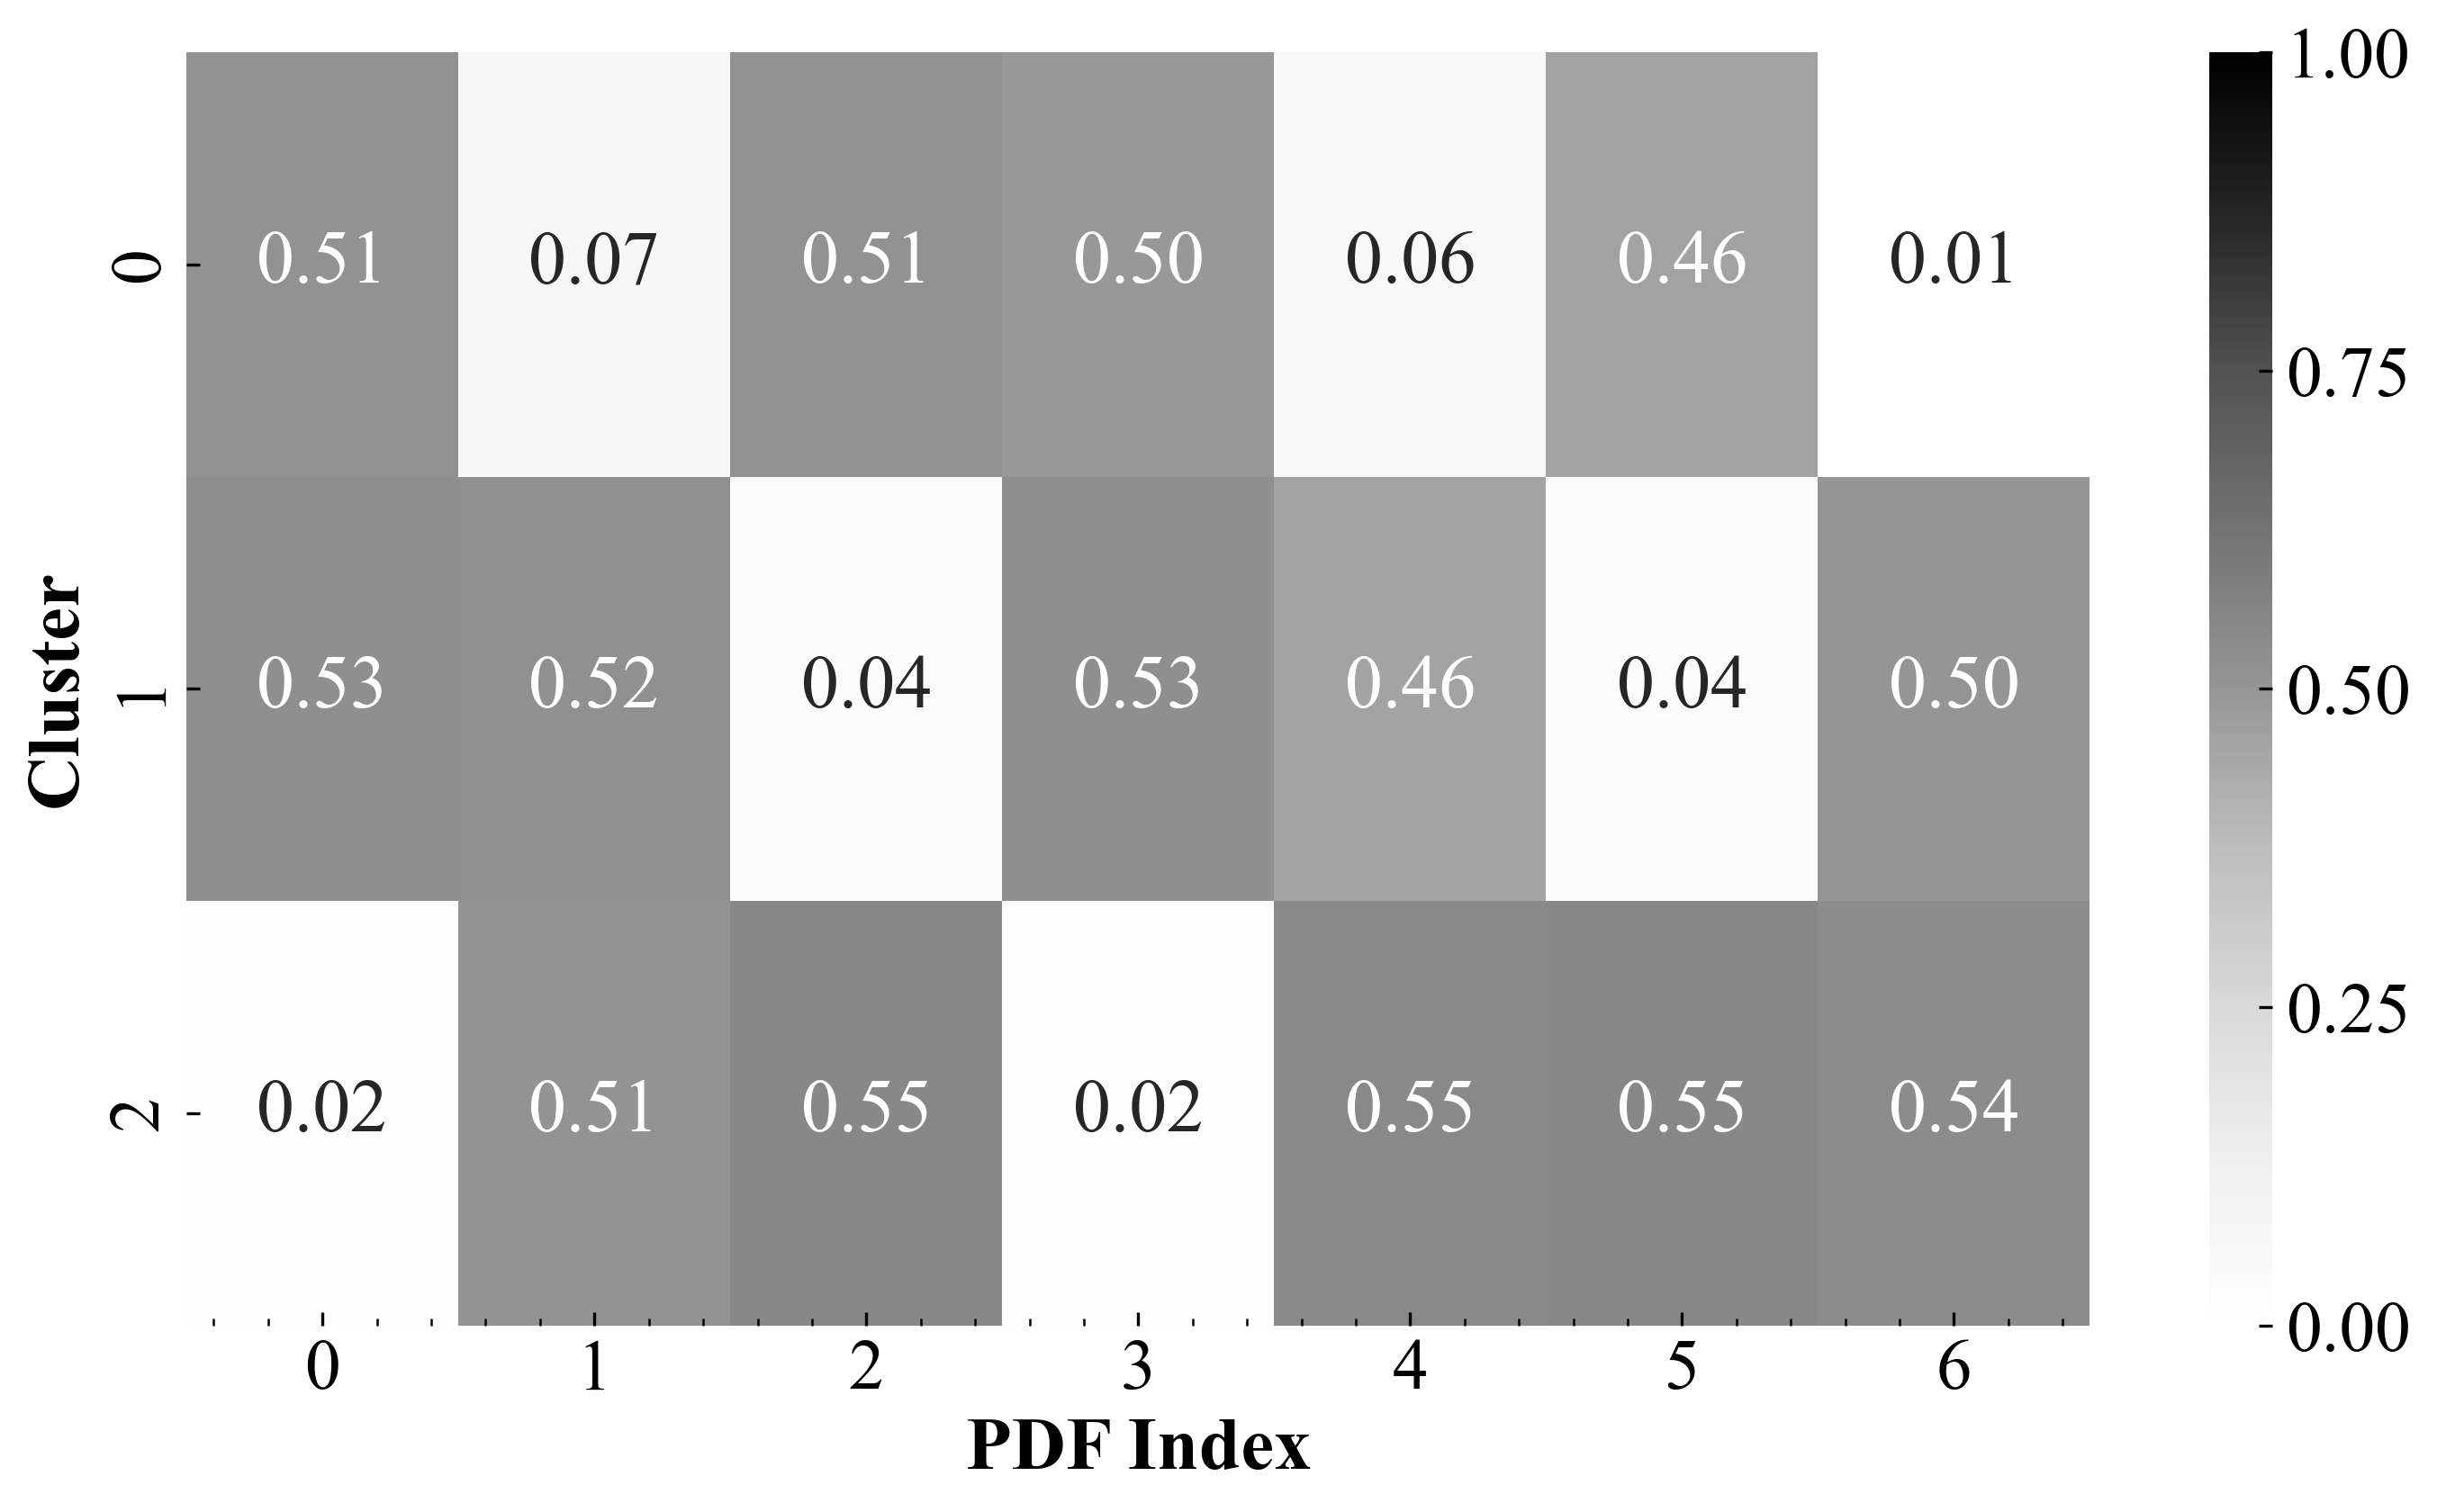

In [19]:
# plotHeatmap_U(U)
plt.figure(figsize=(10, 6))
temp(fontsize=20)

sns.heatmap(
	cluster._compute_distance_matrix().T,
	annot=True,
	fmt=".2f",
	cmap='Greys',
	cbar=True,
   vmin=0.0,           # ép min = 0
	vmax=1.0,           # ép max = 1
	cbar_kws={
		"ticks": np.linspace(0, 1, 5),  # 0, 0.2, ..., 1.0
		"format": "%.2f",
	},
)

plt.ylabel('Cluster')
plt.xlabel('PDF Index')
plt.tight_layout()
# plt.savefig("FCF_D9.pdf", bbox_inches='tight')

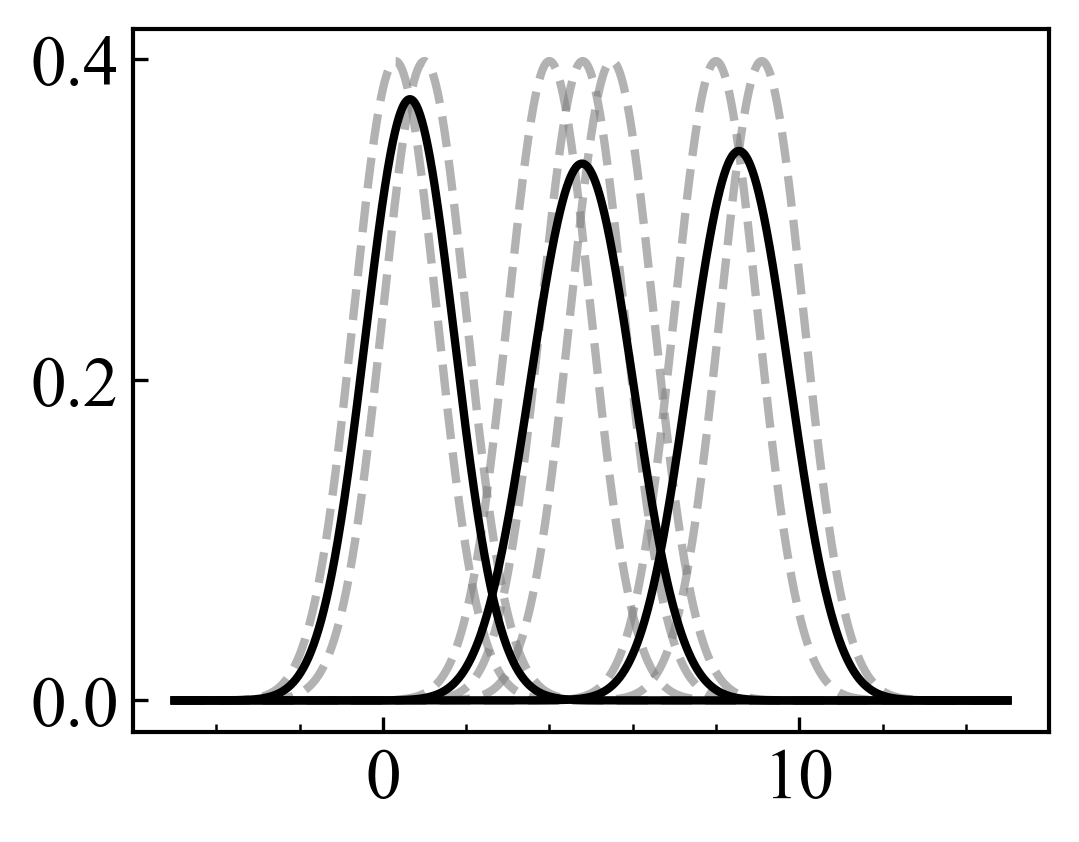

In [20]:
# plotPDF_Theta(grid_x, F_data, theta=Theta)
plt.figure()
temp(fontsize=18, w=10, h=5, u='centimeters')

# pdfs
for i in range(cluster.num_pdfs):
	plt.plot(grid_x, F_data[i, :], lw=2, color='gray', linestyle='--', alpha=0.6)

# prototype
for j in range(cluster.num_clusters):
	plt.plot(grid_x, Theta[j, :], lw=2, linestyle='-', color='black')

plt.tight_layout()
plt.savefig("FCF_V4.pdf", bbox_inches='tight')

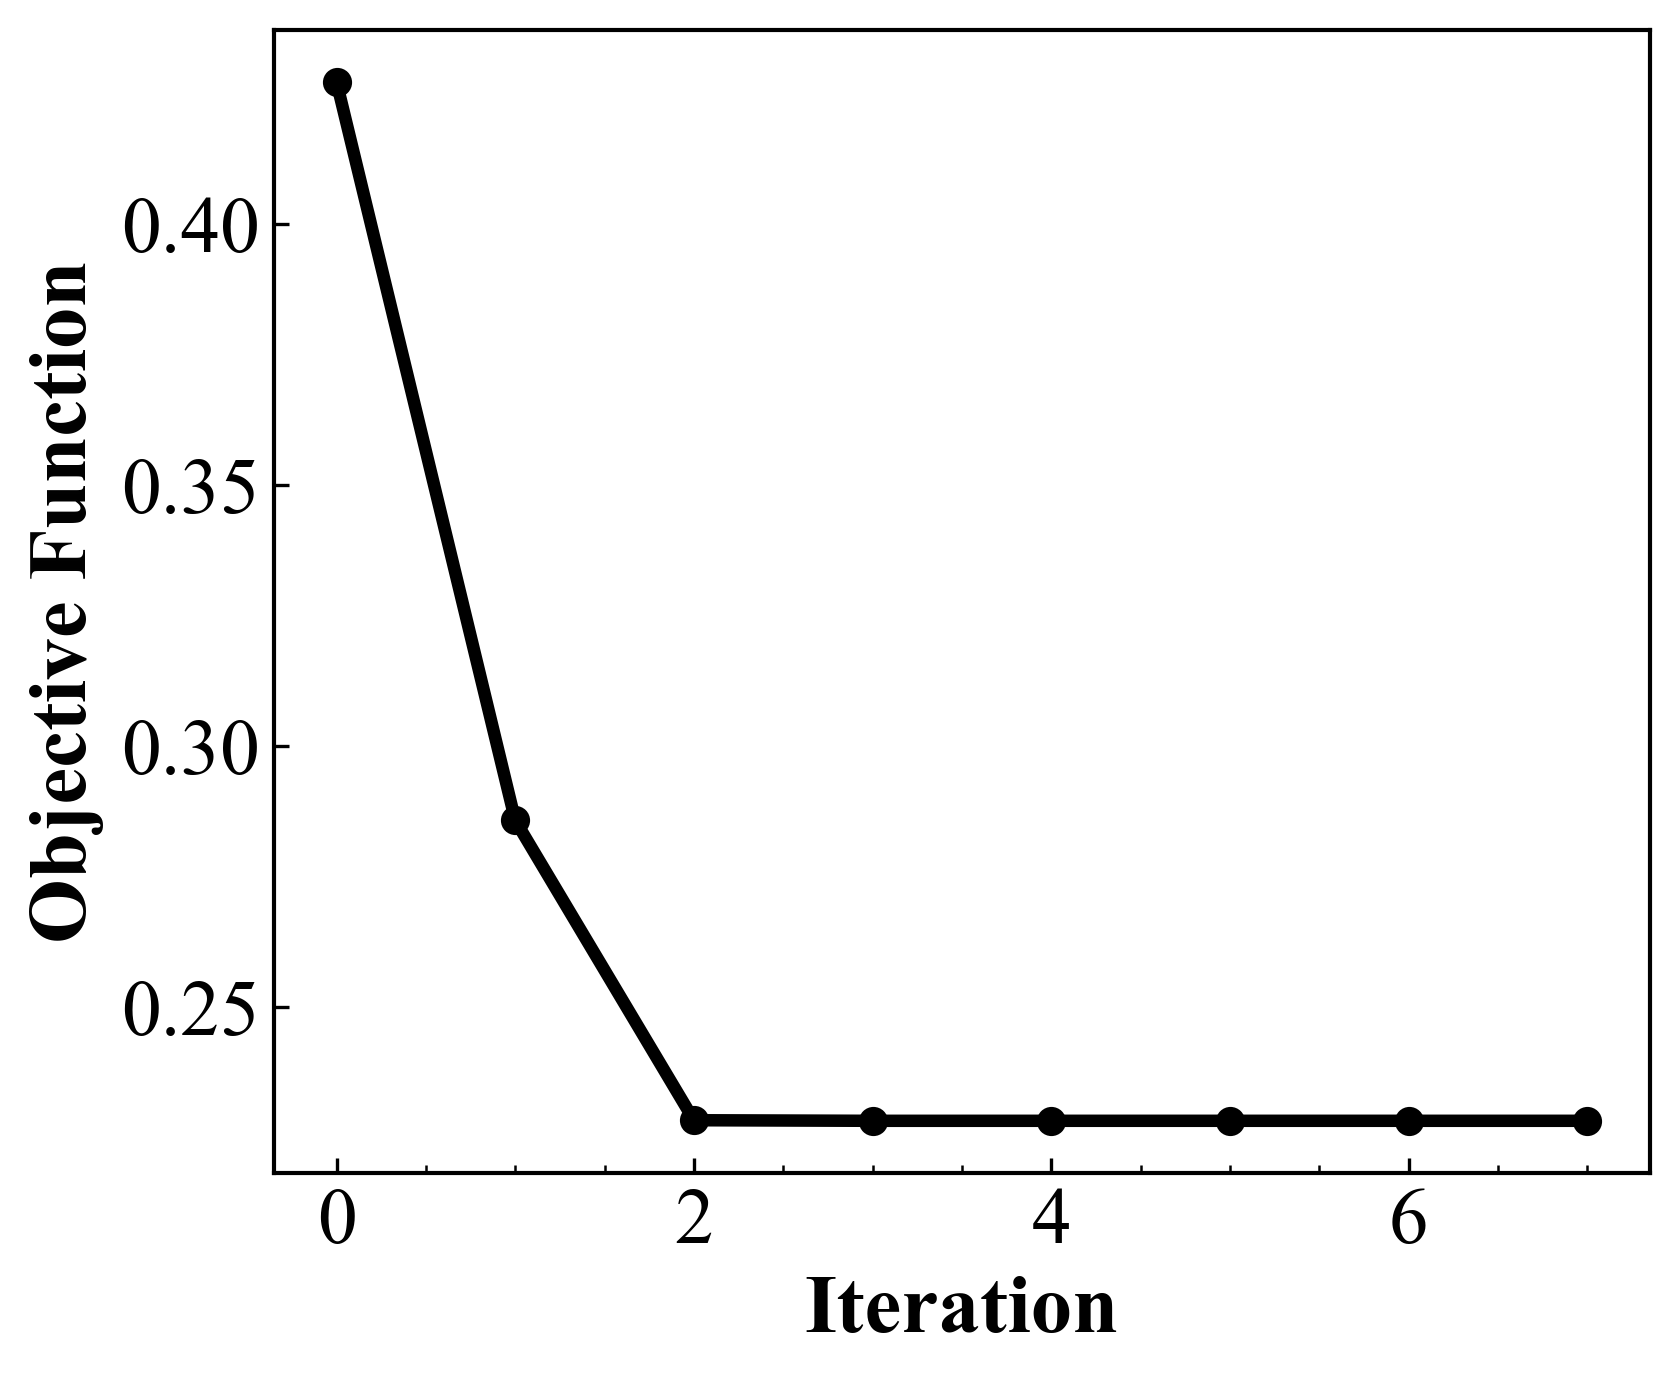

In [21]:
# plot_OF(J)
plt.figure(figsize=(6, 5))
temp(fontsize=20)

plt.plot(J, lw = 3,color = 'black', marker='o')
plt.xlabel("Iteration")
plt.ylabel("Objective Function")
plt.tight_layout()

In [22]:
from utils.vali import CVI

evaluator = CVI(distance_metric='L2',bandwidth=bandwidth, grid=grid_x)


sil = evaluator.silhouette_index(F_data, labels)
dunn = evaluator.dunn_index(F_data, labels)
dbi = evaluator.davies_bouldin_index(F_data, labels)

print(f"Silhouette = {sil:.4f}, Dunn = {dunn:.4f}, DBI = {dbi:.4f}")

Silhouette = 0.7381, Dunn = 1.3554, DBI = 0.5339


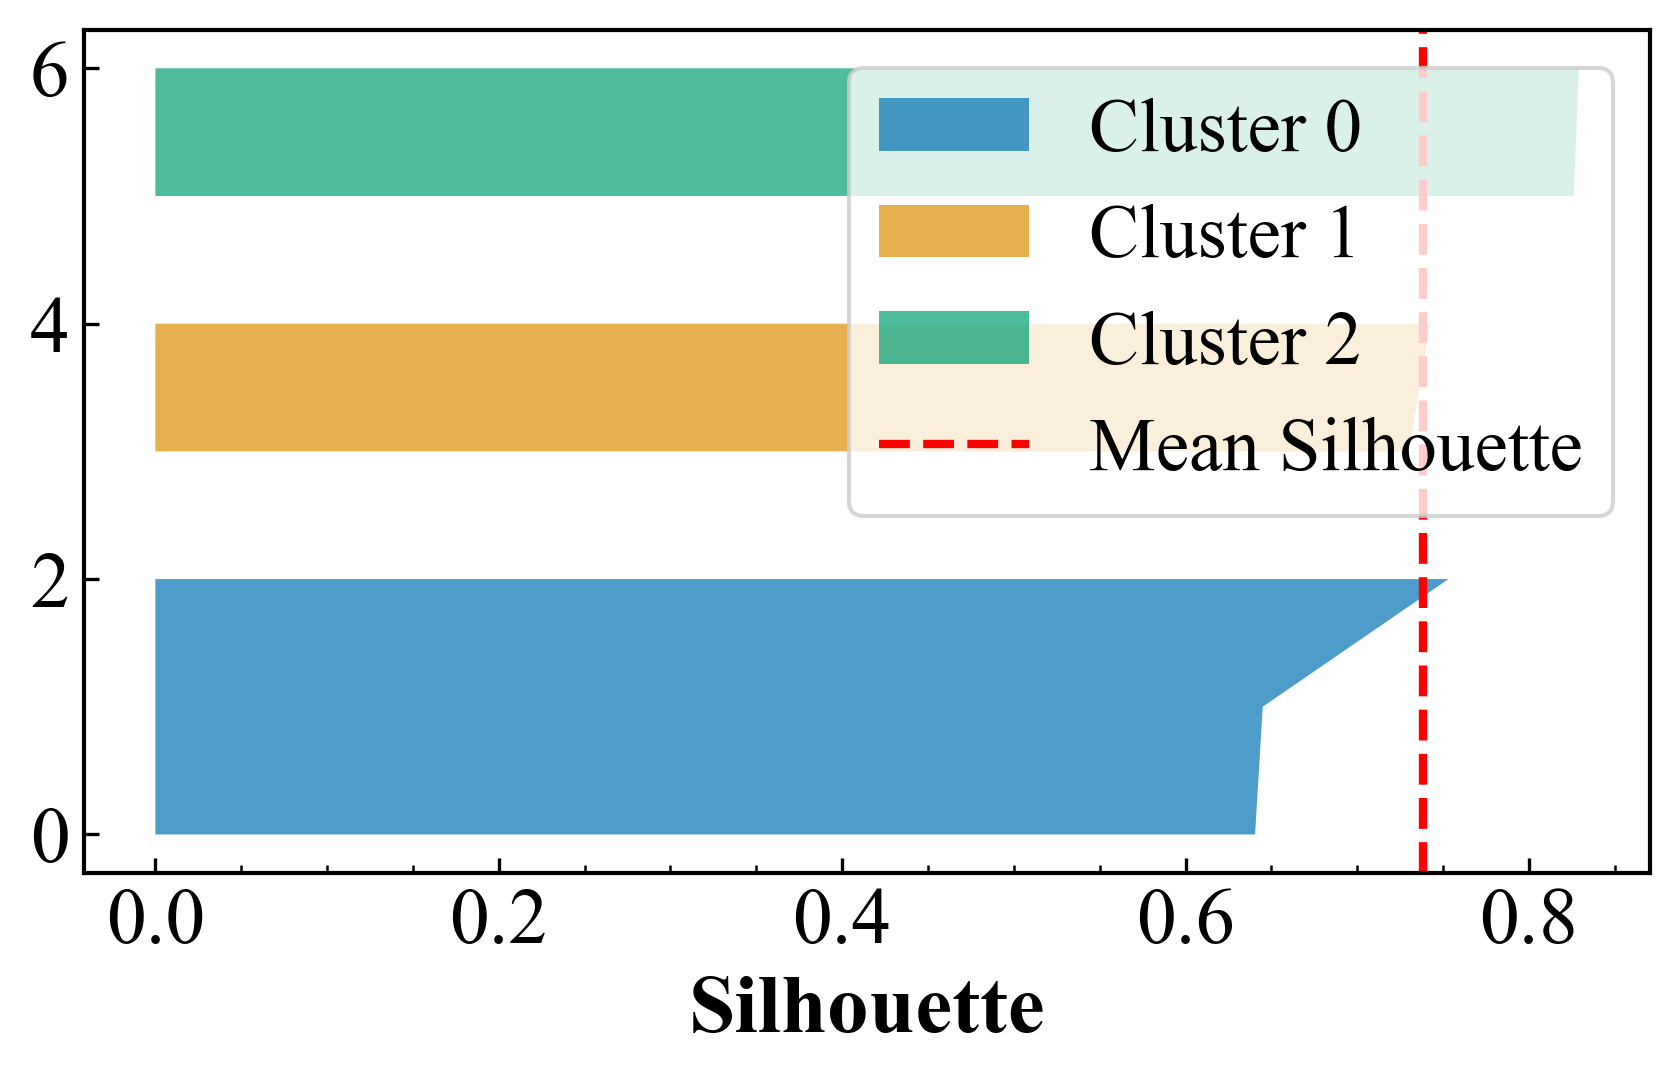

Silhouette fj: [0.82907416 0.64049635 0.74235779 0.82611234 0.64497216 0.73019066
 0.75316892]


In [23]:
sil_values = plot_silhouette_values(F_data, labels,
                                    distance_metric='L2',
                                    bandwidth=bandwidth,
                                    grid=grid_x)
print("Silhouette fj:", sil_values)

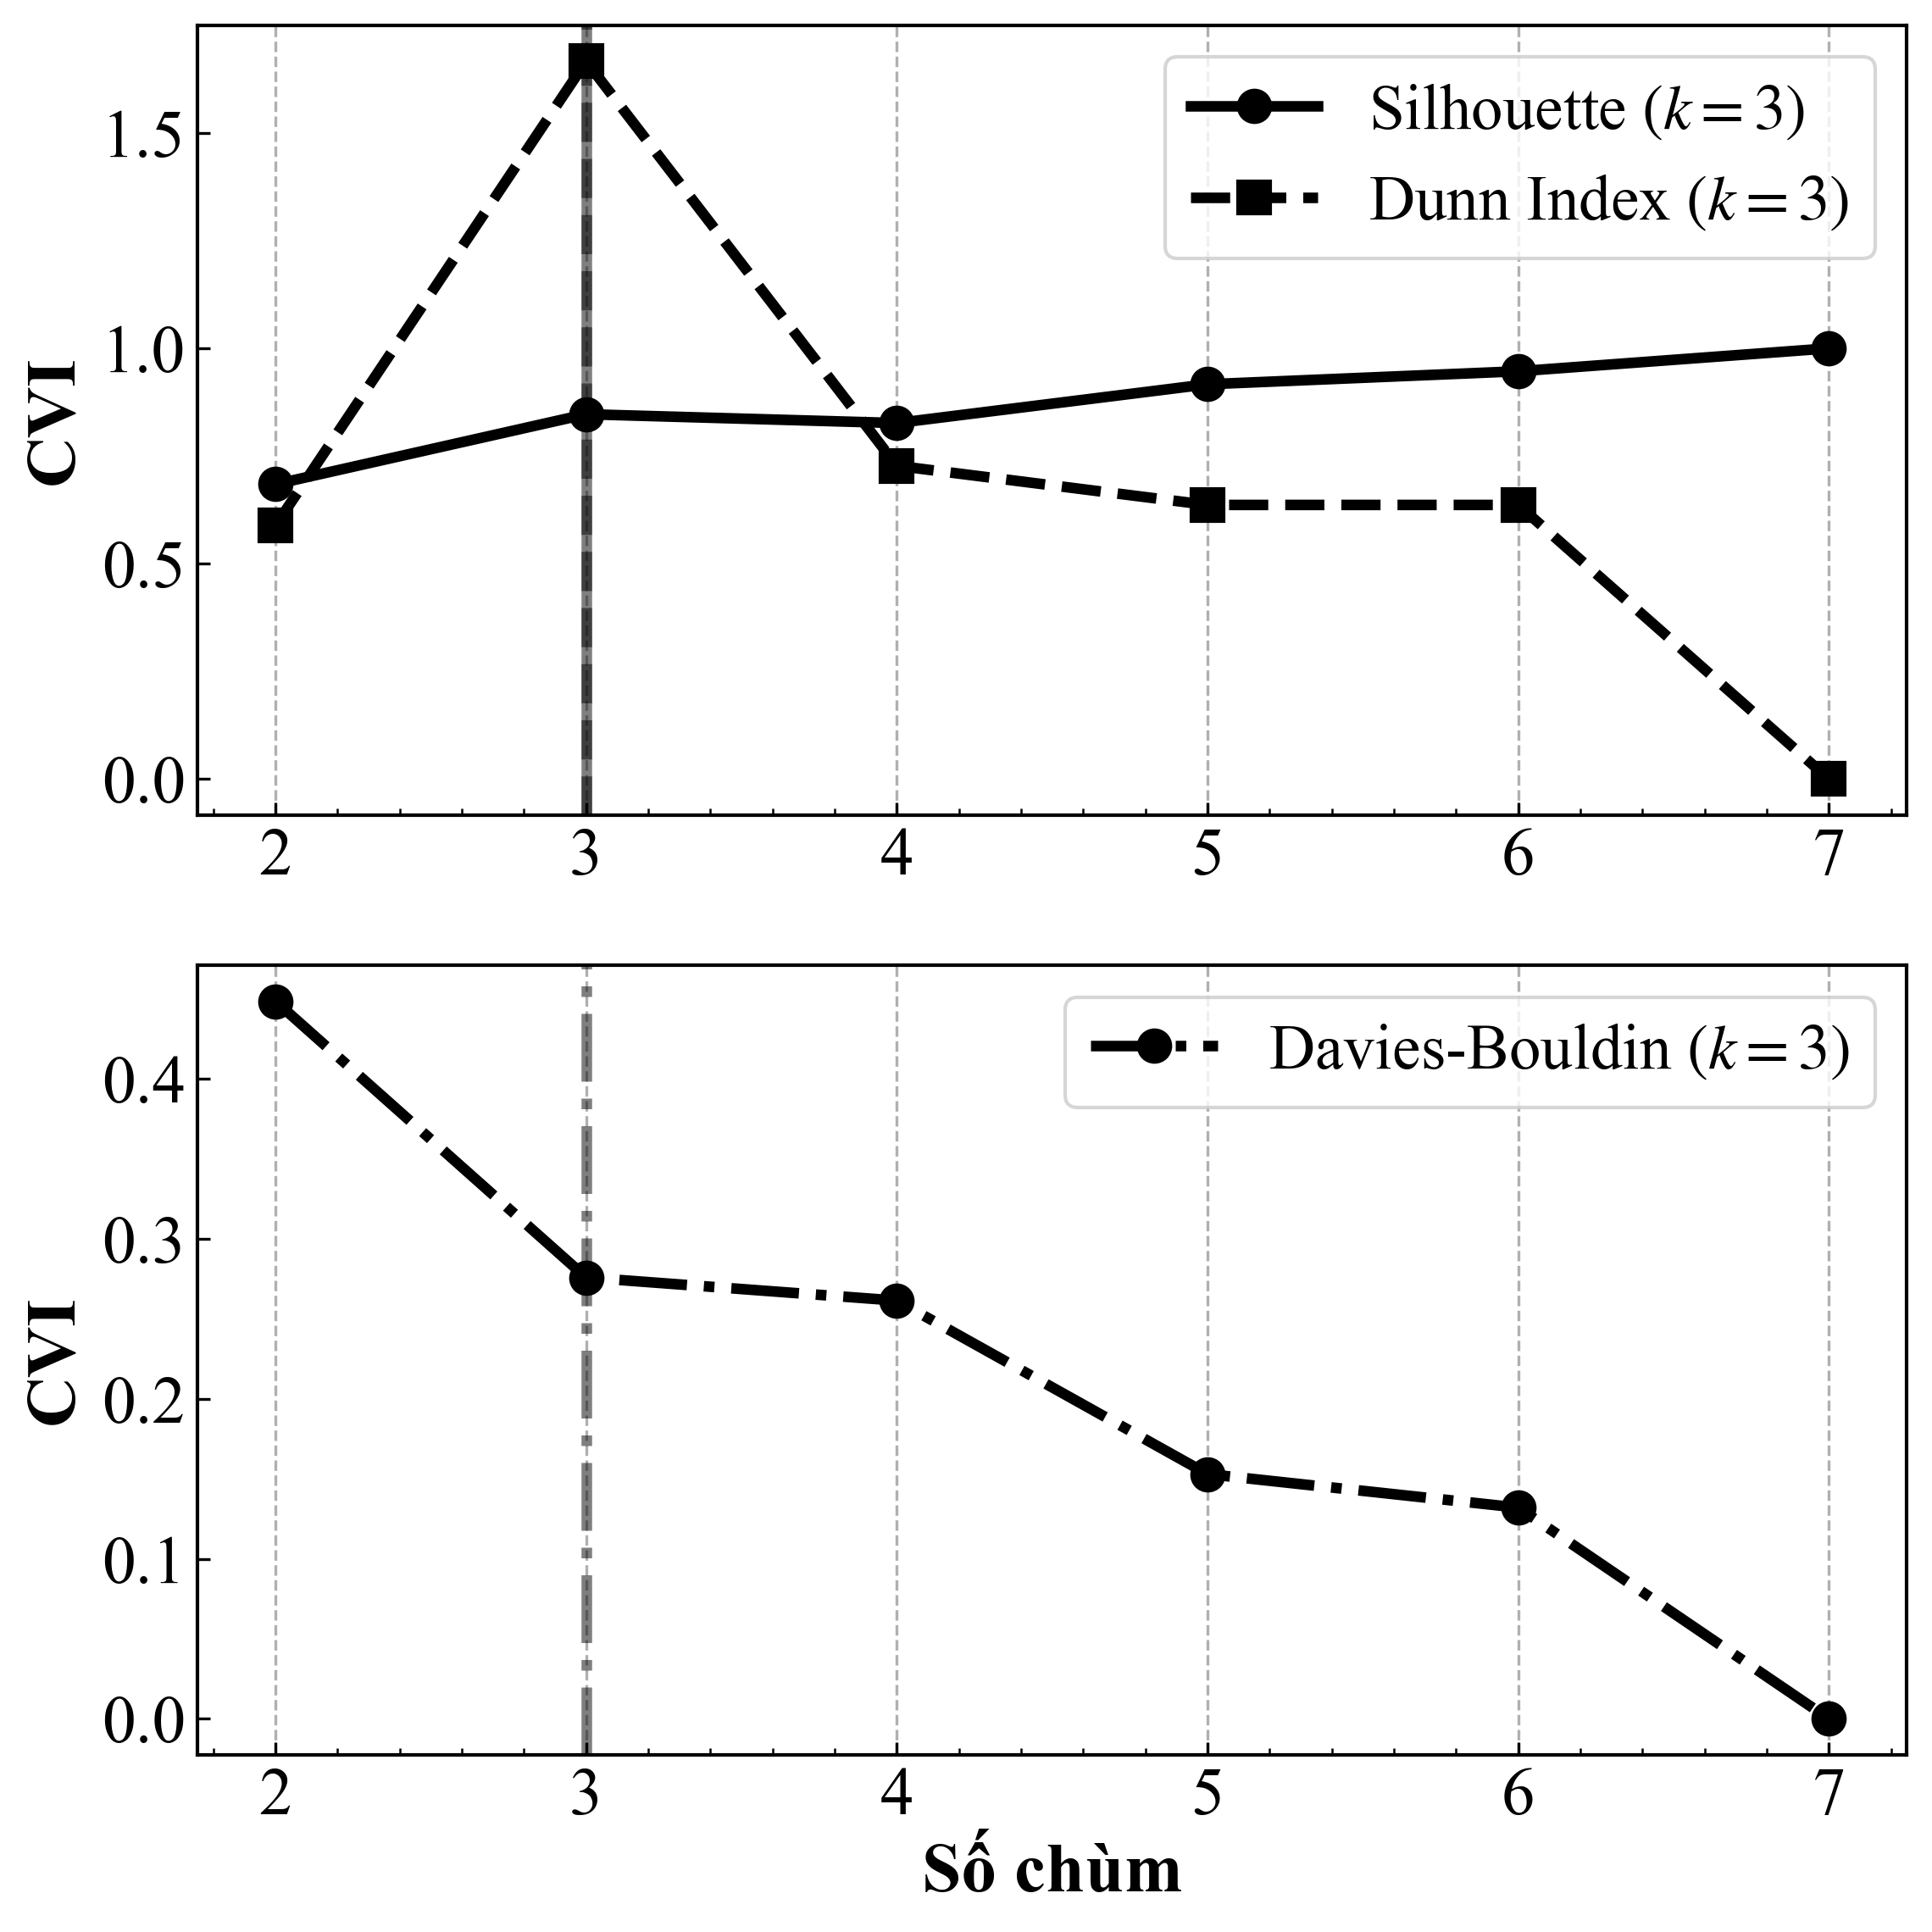

In [24]:
num_clusters_range = range(2, 8)
silhouette_scores, dunn_scores, dbi_scores = [], [], []

for k in num_clusters_range:
	cluster = FCF.Model(
	grid_x=grid_x,
	num_clusters=k,
	fuzziness=2,
	max_iterations=100,
	tolerance=1e-5,
	centroid_mode="frechet",
	distance_metric='W2',
	verbose=False
	)
	cluster.fit(F_data)
	labels = cluster.get_hard_assignments()
	evaluator = CVI(distance_metric='W2', bandwidth=bandwidth, grid=grid_x)

	sil = evaluator.silhouette_index(F_data, labels)
	dunn = evaluator.dunn_index(F_data, labels)
	dbi = evaluator.davies_bouldin_index(F_data, labels)

	silhouette_scores.append(sil)
	dunn_scores.append(dunn)
	dbi_scores.append(dbi)

plot_CVI_with_k(num_clusters_range, silhouette_scores, dunn_scores, dbi_scores)